# DEMO: Data Exploration and Feature Engineering

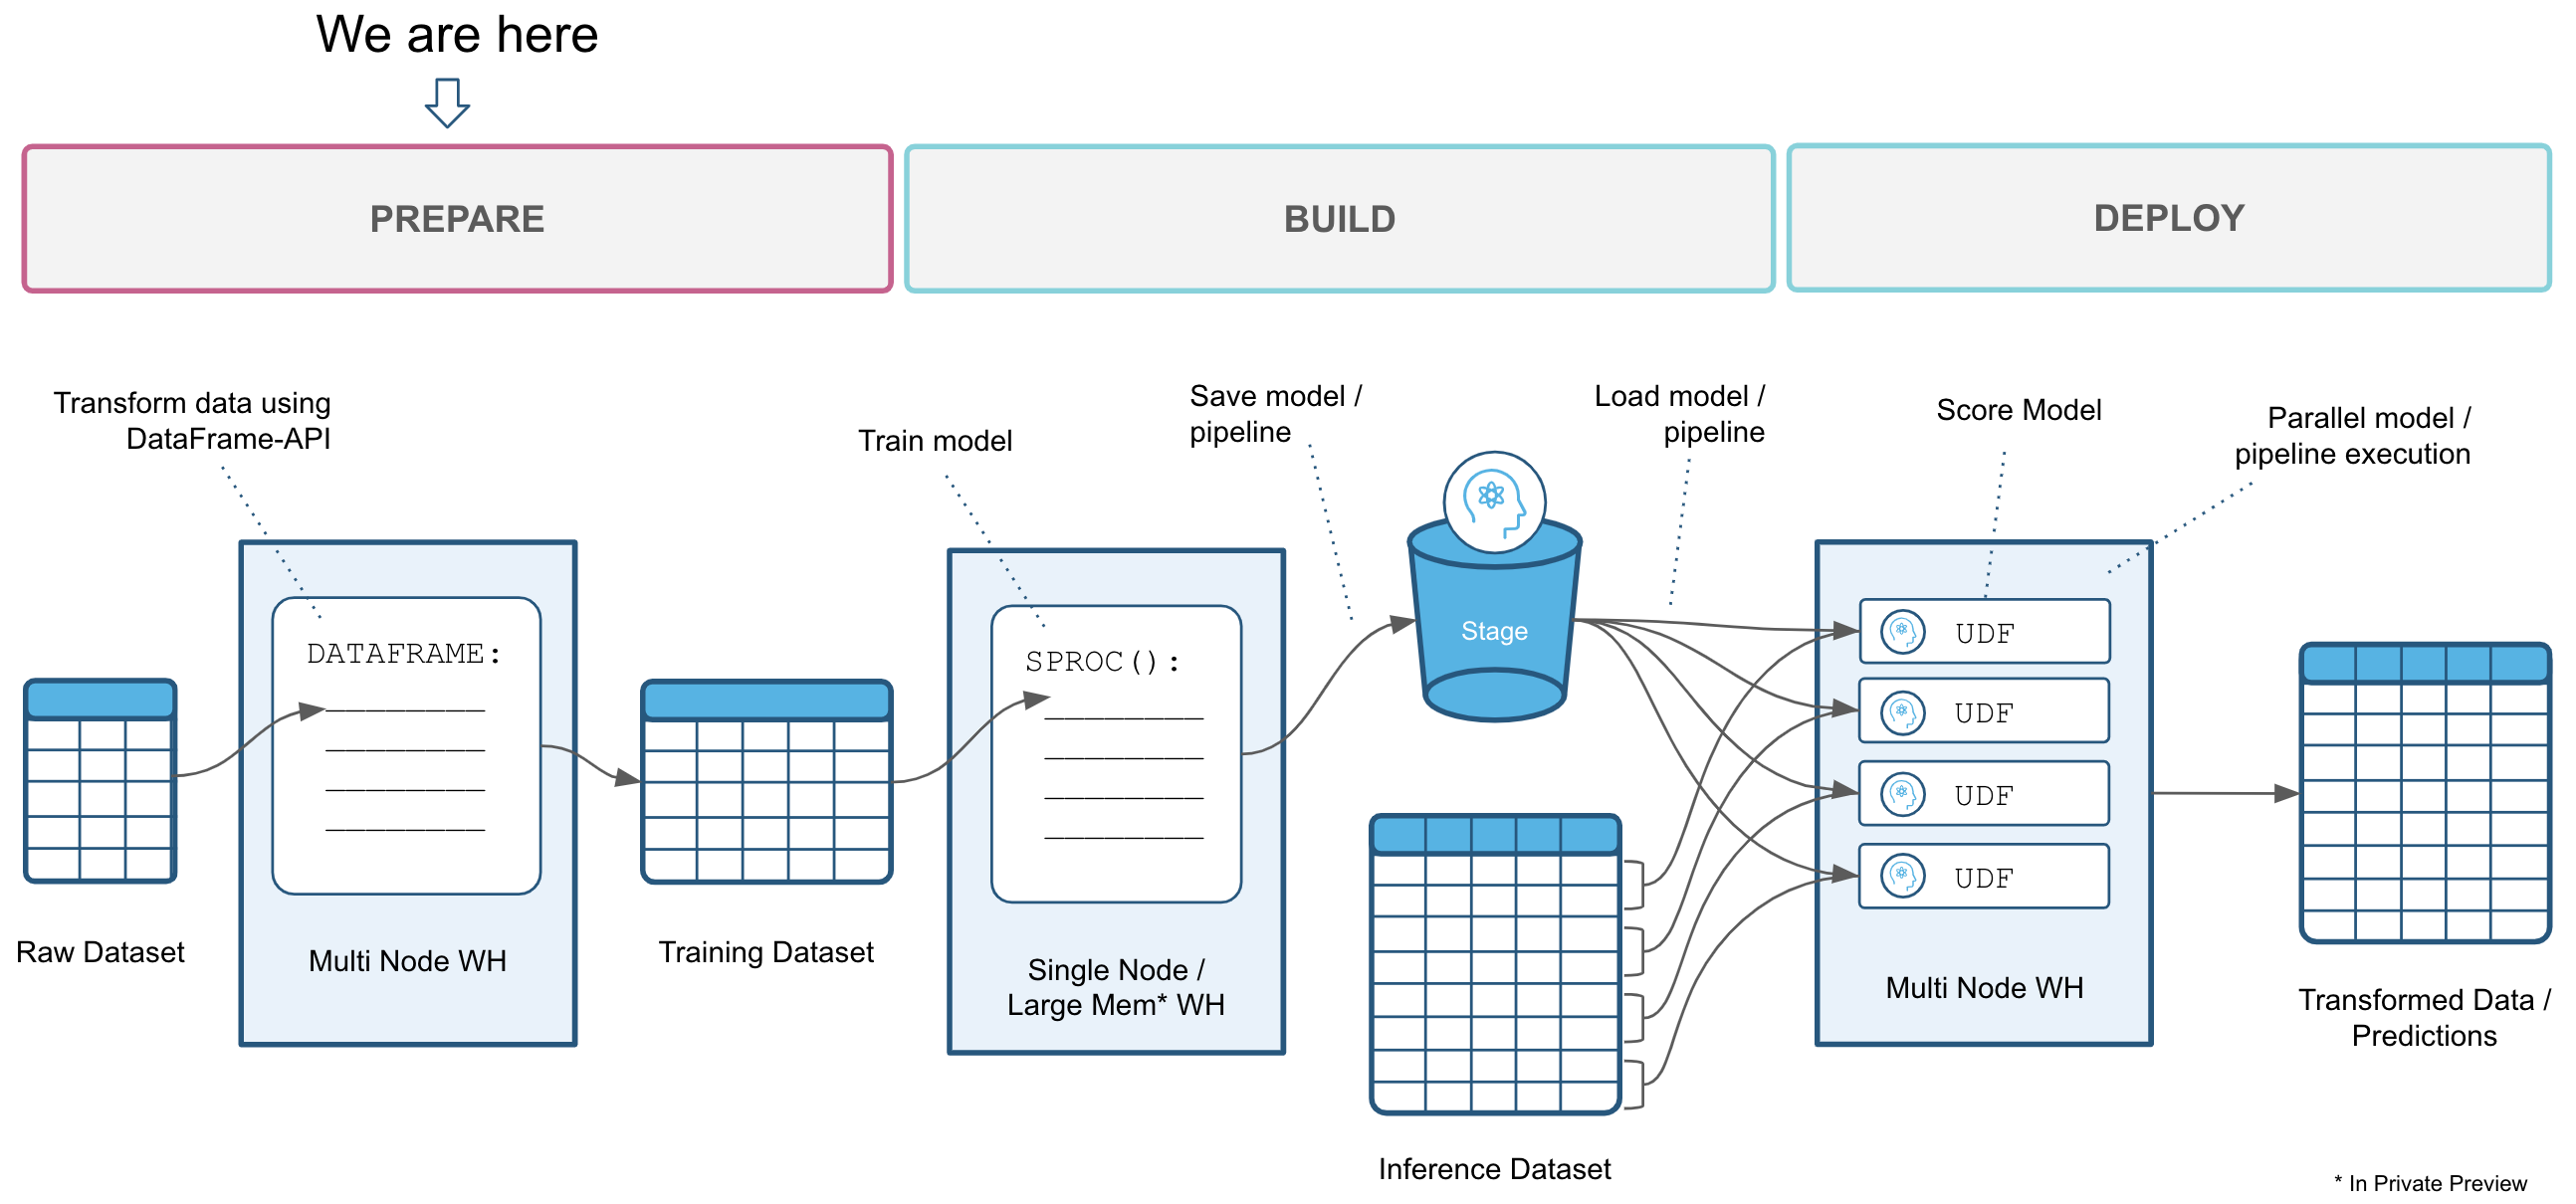

## Imports

In [1]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window

import sys
import getpass
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Create Snowpark Session

In [2]:
accountname = getpass.getpass() # ORGNAME-ACCOUNTNAME (separated by minus sign)

········


In [3]:
username = getpass.getpass()    # SNOWFLAKE-USERNAME

········


In [4]:
password = getpass.getpass()    # SNOWFLAKE-PASSWORD

········


In [5]:
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "database": "HOL_DB",
    "schema": "PUBLIC",
    "warehouse": "HOL_WH"
}

session = Session.builder.configs(connection_parameters).create()

## Snowpark DataFrames vs. Pandas DataFrames

In [6]:
# Creating a Pandas DataFrame
pandas_df = pd.read_csv('data/application_record.csv.zip')
print(type(pandas_df))

<class 'pandas.core.frame.DataFrame'>


In [7]:
# Creating a Snowpark DataFrame
snowpark_df = session.table('APPLICATION_RECORD')
print(type(snowpark_df))

<class 'snowflake.snowpark.table.Table'>


In [8]:
# Compare size
print('Size in MB of Pandas DataFrame in Memory:\n', np.round(sys.getsizeof(pandas_df) / (1024.0**2), 2))
print('Size in MB of Snowpark DataFrame in Memory:\n', np.round(sys.getsizeof(snowpark_df) / (1024.0**2), 2))

Size in MB of Pandas DataFrame in Memory:
 251.15
Size in MB of Snowpark DataFrame in Memory:
 0.0


In [9]:
# Converting a Snowpark DataFrame to Pandas DataFrame
pandas_df2 = snowpark_df.to_pandas()

In [10]:
pandas_df.shape, pandas_df2.shape

((438557, 18), (438557, 18))

In [11]:
# Showing a Snowpark DataFrame
# snowpark_df.show() <- also possible
snowpark_df.limit(5).to_pandas() # <- collects first 5 rows and displays as pandas-dataframe

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,None,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,None,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


## Simple Transformations

In [12]:
# Select specific columns
snowpark_df = snowpark_df.select('CODE_GENDER','NAME_INCOME_TYPE','DAYS_BIRTH',)
# snowpark_df = snowpark_df[['CODE_GENDER','NAME_INCOME_TYPE','DAYS_BIRTH']] -> pandas-like selection
snowpark_df.limit(5).to_pandas()

,CODE_GENDER,NAME_INCOME_TYPE,DAYS_BIRTH
0,M,Working,-12005
1,M,Working,-12005
2,M,Working,-21474
3,F,Commercial associate,-19110
4,F,Commercial associate,-19110


In [13]:
# Create a new column
# Formula: Absolute Value of DAYS_BIRTH divided by 365 days rounded down
snowpark_df = snowpark_df.with_column('AGE', F.floor(F.abs(F.col('DAYS_BIRTH')) / 365))
snowpark_df.limit(5).to_pandas()

,CODE_GENDER,NAME_INCOME_TYPE,DAYS_BIRTH,AGE
0,M,Working,-12005,32
1,M,Working,-12005,32
2,M,Working,-21474,58
3,F,Commercial associate,-19110,52
4,F,Commercial associate,-19110,52


In [14]:
# Drop a column
snowpark_df = snowpark_df.drop('DAYS_BIRTH')
snowpark_df.limit(5).to_pandas()

,CODE_GENDER,NAME_INCOME_TYPE,AGE
0,M,Working,32
1,M,Working,32
2,M,Working,58
3,F,Commercial associate,52
4,F,Commercial associate,52


In [15]:
# Filter data
snowpark_df = snowpark_df.filter(F.col('NAME_INCOME_TYPE').in_(['Pensioner','Student']))
snowpark_df.limit(5).to_pandas()

,CODE_GENDER,NAME_INCOME_TYPE,AGE
0,F,Pensioner,61
1,F,Pensioner,61
2,F,Pensioner,61
3,F,Pensioner,55
4,F,Pensioner,61


In [16]:
# Aggregate data
snowpark_df = snowpark_df.group_by(['CODE_GENDER','NAME_INCOME_TYPE']).agg([F.avg('AGE').as_('AVG_AGE')])
snowpark_df.limit(5).to_pandas()

,CODE_GENDER,NAME_INCOME_TYPE,AVG_AGE
0,F,Pensioner,59.188624
1,M,Pensioner,57.685482
2,F,Student,46.090909
3,M,Student,27.166667


In [17]:
# Sort data
snowpark_df = snowpark_df.sort(F.col('AVG_AGE').desc())
snowpark_df.limit(5).to_pandas()

,CODE_GENDER,NAME_INCOME_TYPE,AVG_AGE
0,F,Pensioner,59.188624
1,M,Pensioner,57.685482
2,F,Student,46.090909
3,M,Student,27.166667


## Simple Data Analysis

In [18]:
# Creating a Snowpark DataFrame
snowpark_df = session.table('APPLICATION_RECORD')

In [19]:
# Number of rows in dataset
snowpark_df.count()

438557

In [20]:
# Lets drop duplicates based on ID
snowpark_df = snowpark_df.drop_duplicates('ID')
snowpark_df.count()

438510

In [21]:
# Calculating various statistics per column
snowpark_df.describe().to_pandas()

,SUMMARY,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,mean,6.022035e+06,None,None,None,0.427381,1.875254e+05,None,None,None,None,-15998.022996,60566.188769,1.0,0.206128,0.287770,0.108200,None,2.194463
1,count,4.385100e+05,438510,438510,438510,438510.000000,4.385100e+05,438510,438510,438510,438510,438510.000000,438510.000000,438510.0,438510.000000,438510.000000,438510.000000,304317,438510.000000
2,min,5.008804e+06,F,N,N,0.000000,2.610000e+04,Commercial associate,Academic degree,Civil marriage,Co-op apartment,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,Accountants,1.000000
3,stddev,5.714962e+05,None,None,None,0.724874,1.100893e+05,None,None,None,None,4185.016222,138770.072835,0.0,0.404523,0.452724,0.310633,None,0.897192
4,max,7.999952e+06,M,Y,Y,19.000000,6.750000e+06,Working,Secondary / secondary special,Widow,With parents,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,Waiters/barmen staff,20.000000


In [22]:
# Get all categorical columns
numeric_types = [T.DecimalType, T.LongType, T.DoubleType, T.FloatType, T.IntegerType]
numeric_columns = [c.name for c in snowpark_df.schema.fields if type(c.datatype) in numeric_types]
numeric_columns

['ID',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS']

In [23]:
# Get all numerical columns
categorical_types = [T.StringType]
categorical_columns = [c.name for c in snowpark_df.schema.fields if type(c.datatype) in categorical_types]
categorical_columns

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE']

In [24]:
# Average Income per Income Type and Gender
analysis_df = snowpark_df.group_by(['NAME_INCOME_TYPE','CODE_GENDER']).agg([F.mean('AMT_INCOME_TOTAL').as_('AVG_INCOME')])
analysis_df = analysis_df.sort('NAME_INCOME_TYPE', F.col('AVG_INCOME').desc())
analysis_df.to_pandas()

,NAME_INCOME_TYPE,CODE_GENDER,AVG_INCOME
0,Commercial associate,M,249208.086423
1,Commercial associate,F,206579.174633
2,Pensioner,M,169049.774167
3,Pensioner,F,150729.612554
4,State servant,M,237034.154143
5,State servant,F,186152.984290
6,Student,F,165272.727273
7,Student,M,149250.000000
8,Working,M,202170.824274
9,Working,F,168679.568994


In [25]:
# Simple Missing Value Imputation
snowpark_df = snowpark_df.fillna(snowpark_df[[F.mode('OCCUPATION_TYPE')]].collect()[0][0], subset='OCCUPATION_TYPE')
snowpark_df.describe().to_pandas()

,SUMMARY,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,count,4.385100e+05,438510,438510,438510,438510.000000,4.385100e+05,438510,438510,438510,438510,438510.000000,438510.000000,438510.0,438510.000000,438510.000000,438510.000000,438510,438510.000000
1,mean,6.022035e+06,None,None,None,0.427381,1.875254e+05,None,None,None,None,-15998.022996,60566.188769,1.0,0.206128,0.287770,0.108200,None,2.194463
2,min,5.008804e+06,F,N,N,0.000000,2.610000e+04,Commercial associate,Academic degree,Civil marriage,Co-op apartment,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,Accountants,1.000000
3,stddev,5.714962e+05,None,None,None,0.724874,1.100893e+05,None,None,None,None,4185.016222,138770.072835,0.0,0.404523,0.452724,0.310633,None,0.897192
4,max,7.999952e+06,M,Y,Y,19.000000,6.750000e+06,Working,Secondary / secondary special,Widow,With parents,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,Waiters/barmen staff,20.000000


In [26]:
# Number of unique values per categorical column
unique_values = []
for column in categorical_columns:
    unique_values.append([column, snowpark_df.select(column).distinct().count()])
pd.DataFrame(unique_values, columns=['COLUMN_NAME','NUM_UNIQUE_VALUES'])

,COLUMN_NAME,NUM_UNIQUE_VALUES
0,CODE_GENDER,2
1,FLAG_OWN_CAR,2
2,FLAG_OWN_REALTY,2
3,NAME_INCOME_TYPE,5
4,NAME_EDUCATION_TYPE,5
5,NAME_FAMILY_STATUS,5
6,NAME_HOUSING_TYPE,6
7,OCCUPATION_TYPE,18


## Persist Transformations

In [27]:
snowpark_df.write.save_as_table(table_name='MY_FIRST_ANALYSIS', mode='overwrite')